In [1]:
%matplotlib inline

import time
import datetime

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

from scipy.optimize import curve_fit
from jupyterthemes import jtplot

jtplot.style(theme='onedork')

In [2]:
# Data from:
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [3]:
df = pd.read_csv(url, index_col=[0,1])
df

Lat       Long  1/22/20  1/23/20  \
Province/State Country/Region                                                  
NaN            Afghanistan            33.000000  65.000000        0        0   
               Albania                41.153300  20.168300        0        0   
               Algeria                28.033900   1.659600        0        0   
               Andorra                42.506300   1.521800        0        0   
               Angola                -11.202700  17.873900        0        0   
...                                         ...        ...      ...      ...   
               Western Sahara         24.215500 -12.885800        0        0   
               Sao Tome and Principe   0.186360   6.613081        0        0   
               Yemen                  15.552727  48.516388        0        0   
               Comoros               -11.645500  43.333300        0        0   
               Tajikistan             38.861034  71.276093        0        0   

                                      1/24/20  1/25/20  1/26/20  1/27/20  \
Province/State Country/Region                                              
NaN            Afghanistan                  0        0        0        0   
               Albania                      0        0        0        0   
               Algeria                      0        0        0        0   
               Andorra                      0        0        0        0   
               Angola                       0        0        0        0   
...                                       ...      ...      ...      ...   
               Western Sahara               0        0        0        0   
               Sao Tome and Principe        0        0        0        0   
               Yemen                        0        0        0        0   
               Comoros                      0        0        0        0   
               Tajikistan                   0        0        0        0   

                                      1/28/20  1/29/20  ...  4/25/20  4/26/20  \
Province/State Country/Region                           ...                     
NaN            Afghanistan                  0        0  ...       47       50   
               Albania                      0        0  ...       27       28   
               Algeria                      0        0  ...      419      425   
               Andorra                      0        0  ...       40       40   
               Angola                       0        0  ...        2        2   
...                                       ...      ...  ...      ...      ...   
               Western Sahara               0        0  ...        0        0   
               Sao Tome and Principe        0        0  ...        0        0   
               Yemen                        0        0  ...        0        0   
               Comoros                      0        0  ...        0        0   
               Tajikistan                   0        0  ...        0        0   

                                      4/27/20  4/28/20  4/29/20  4/30/20  \
Province/State Country/Region                                              
NaN            Afghanistan                 57       58       60       64   
               Albania                     28       30       30       31   
               Algeria                    432      437      444      450   
               Andorra                     40       41       42       42   
               Angola                       2        2        2        2   
...                                       ...      ...      ...      ...   
               Western Sahara               0        0        0        0   
               Sao Tome and Principe        0        0        0        0   
               Yemen                        0        0        0        2   
               Comoros                      0        0        0        0   
               Tajikistan                   0   

In [4]:
df2 = df.drop(['Lat', 'Long'], 1).groupby(level=1).sum().T
df2.index = pd.to_datetime(df2.index)
last_date = df2.index[-1]

df2

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30,64,31,450,42,2,3,218,32,93,584,...,26842,17,9,16,0,2,0,2,3,4
2020-05-01,68,31,453,43,2,3,225,33,93,589,...,27583,17,9,10,0,2,0,2,3,4
2020-05-02,72,31,459,44,2,3,237,33,94,596,...,28205,17,9,10,0,2,0,2,3,4
2020-05-03,85,31,463,45,2,3,246,35,95,598,...,28520,17,10,10,0,2,0,2,3,4


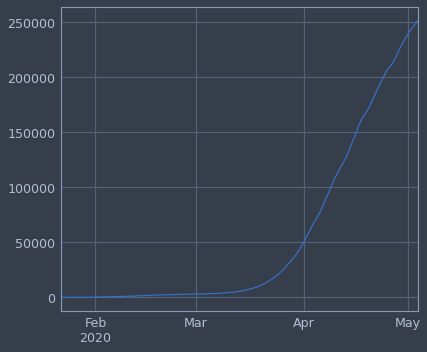

In [5]:
df2.T.sum().plot()

In [6]:
len(df2.columns)

187

In [7]:
df_exchina = df2.drop('China', 1)
# df_exchina = df_exchina.drop('US', 1)

df_exchina = df_exchina[df_exchina.T.sum() > 1]
len(df_exchina.columns)

186

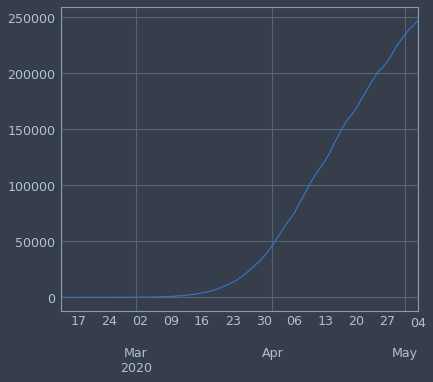

In [8]:
df_exchina.T.sum().plot()

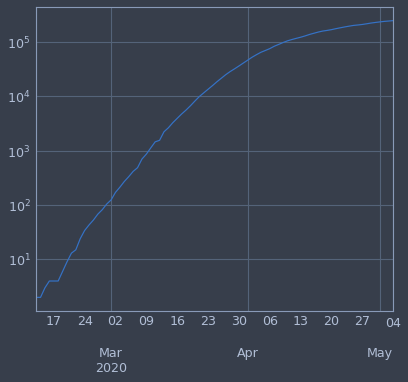

In [9]:
df_exchina.T.sum().plot(logy = True)

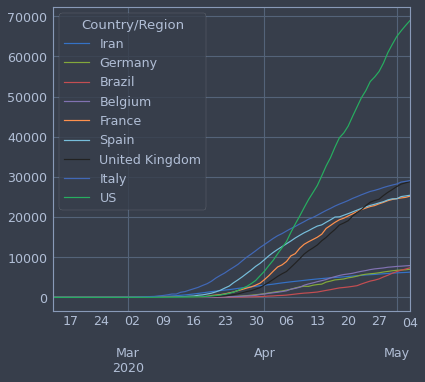

In [10]:
df_exchina.T.sort_values(by=last_date).tail(9).T.plot()

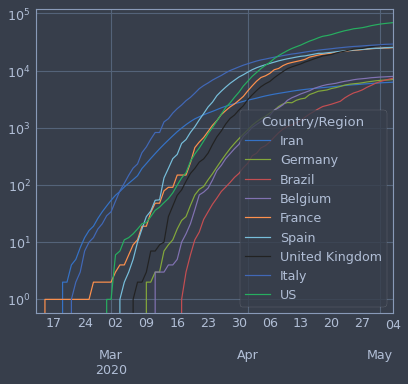

In [11]:
df_exchina.T.sort_values(by=last_date).tail(9).T.plot(logy = True)

In [12]:
df_exchina.T.sort_values(by=last_date).tail(9).T.tail(10)

Country/Region,Iran,Germany,Brazil,Belgium,France,Spain,United Kingdom,Italy,US
2020-04-25,5650,5877,4057,6917,22617,22902,23697,26384,53755
2020-04-26,5710,5976,4286,7094,22859,23190,24117,26644,54881
2020-04-27,5806,6126,4603,7207,23296,23521,24458,26977,56259
2020-04-28,5877,6314,5083,7331,23663,23822,25369,27359,58355
2020-04-29,5957,6467,5513,7501,24090,24275,26166,27682,60967
2020-04-30,6028,6623,6006,7594,24379,24543,26842,27967,62996
2020-05-01,6091,6736,6412,7703,24597,24543,27583,28236,64943
2020-05-02,6156,6812,6761,7765,24763,25100,28205,28710,66369
2020-05-03,6203,6866,7051,7844,24900,25264,28520,28884,67682
2020-05-04,6277,6993,7367,7924,25204,25428,28809,29079,68922


In [13]:
df_exchina.T.sort_values(by=last_date).tail(9).T.diff().tail(10)

Country/Region,Iran,Germany,Brazil,Belgium,France,Spain,United Kingdom,Italy,US
2020-04-25,76.0,117.0,353.0,238.0,369.0,378.0,844.0,415.0,2262.0
2020-04-26,60.0,99.0,229.0,177.0,242.0,288.0,420.0,260.0,1126.0
2020-04-27,96.0,150.0,317.0,113.0,437.0,331.0,341.0,333.0,1378.0
2020-04-28,71.0,188.0,480.0,124.0,367.0,301.0,911.0,382.0,2096.0
2020-04-29,80.0,153.0,430.0,170.0,427.0,453.0,797.0,323.0,2612.0
2020-04-30,71.0,156.0,493.0,93.0,289.0,268.0,676.0,285.0,2029.0
2020-05-01,63.0,113.0,406.0,109.0,218.0,0.0,741.0,269.0,1947.0
2020-05-02,65.0,76.0,349.0,62.0,166.0,557.0,622.0,474.0,1426.0
2020-05-03,47.0,54.0,290.0,79.0,137.0,164.0,315.0,174.0,1313.0
2020-05-04,74.0,127.0,316.0,80.0,304.0,164.0,289.0,195.0,1240.0


In [14]:
df_exchina.T.sort_values(by=last_date).tail(9).T.diff().diff().tail(10)

Country/Region,Iran,Germany,Brazil,Belgium,France,Spain,United Kingdom,Italy,US
2020-04-25,-17.0,-68.0,-20.0,49.0,-21.0,11.0,-169.0,-5.0,493.0
2020-04-26,-16.0,-18.0,-124.0,-61.0,-127.0,-90.0,-424.0,-155.0,-1136.0
2020-04-27,36.0,51.0,88.0,-64.0,195.0,43.0,-79.0,73.0,252.0
2020-04-28,-25.0,38.0,163.0,11.0,-70.0,-30.0,570.0,49.0,718.0
2020-04-29,9.0,-35.0,-50.0,46.0,60.0,152.0,-114.0,-59.0,516.0
2020-04-30,-9.0,3.0,63.0,-77.0,-138.0,-185.0,-121.0,-38.0,-583.0
2020-05-01,-8.0,-43.0,-87.0,16.0,-71.0,-268.0,65.0,-16.0,-82.0
2020-05-02,2.0,-37.0,-57.0,-47.0,-52.0,557.0,-119.0,205.0,-521.0
2020-05-03,-18.0,-22.0,-59.0,17.0,-29.0,-393.0,-307.0,-300.0,-113.0
2020-05-04,27.0,73.0,26.0,1.0,167.0,0.0,-26.0,21.0,-73.0


In [15]:
def sigmoid(x, sat, td, velo):
    x = np.float64(x)
    
    td *= 1e10
    td *= 1e9
    
    real_sat = 1e5 * sat
    x = x - td
    x /= 1e14
    return real_sat / (1 + np.exp(-x * velo))

x = df_exchina.index
sat = 30000 / 1e5
td = time.time() / 1e10
velo = .1

In [16]:
popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_exchina.index, 
                       ydata = df_exchina.T.sum(), 
                       p0 = (sat, td, velo)
                      )

In [17]:
y_fit = sigmoid(x, *list(popt))

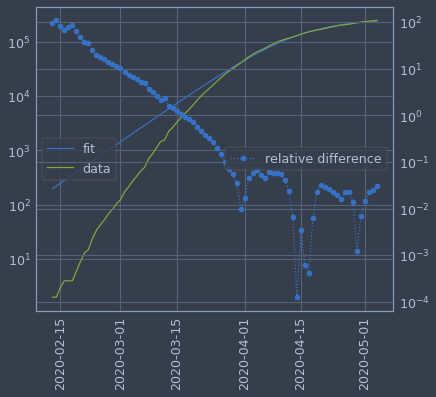

In [18]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)


ax1.semilogy(x, y_fit, label="fit")
ax1.semilogy(x, df_exchina.T.sum(), label="data")

ax2 = ax1.twinx()
ax2.semilogy(x, abs(y_fit - df_exchina.T.sum())/df_exchina.T.sum(), "o:", label="relative difference")
# ax1.legend(loc="lower left")
# ax2.legend(loc="center left")
ax1.legend(loc="center left")
ax2.legend(loc="center right")

In [19]:
th = datetime.datetime.fromtimestamp(popt[1] * 1e10)

In [20]:
f'The total number of Deaths outside China due to Covid-19 will be {int(popt[0] * 1e5)}. Half of those will be reached at {th.strftime("%Y-%B-%d %H:%M")}'

'The total number of Deaths outside China due to Covid-19 will be 263168. Half of those will be reached at 2020-April-14 09:41'

In [21]:
th - df_exchina.index[-1]

Timedelta('-20 days +09:41:25.588308')

In [22]:
df_exchina.T.sum().tail()

2020-04-30    228720
2020-05-01    233982
2020-05-02    239171
2020-05-03    242833
2020-05-04    246900
dtype: int64

In [23]:
df_exchina.T.sum().diff().tail(10)

2020-04-25    6188.0
2020-04-26    3712.0
2020-04-27    4584.0
2020-04-28    6315.0
2020-04-29    6866.0
2020-04-30    5692.0
2020-05-01    5262.0
2020-05-02    5189.0
2020-05-03    3662.0
2020-05-04    4067.0
dtype: float64

In [24]:
tstart = min(df_exchina.index)
tend = tstart + (th - tstart) * 2

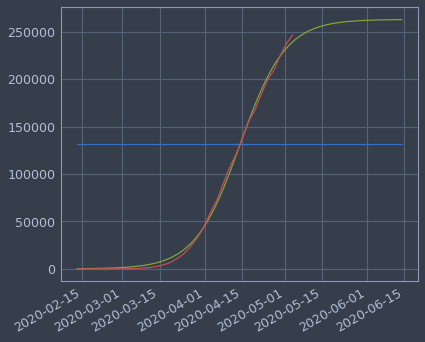

In [25]:
x_extra = np.arange(tstart, tend, datetime.timedelta(days=1)).astype('datetime64[ns]')
y_extra = sigmoid(x_extra, *list(popt))

plt.plot(x_extra, [popt[0]/2 * 1e5 for _ in x_extra])
plt.plot(x_extra, y_extra)
df_exchina.T.sum().plot()
plt.show()

(array([737470., 737485., 737499., 737516., 737530., 737546.]),
 <a list of 6 Text major ticklabel objects>)

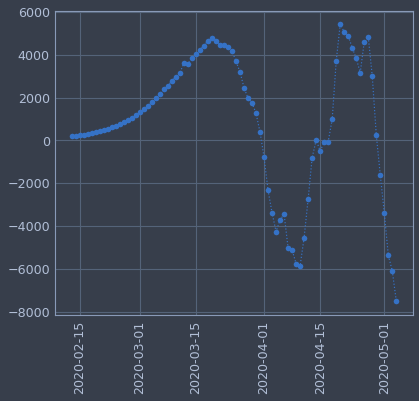

In [26]:
plt.plot(df_exchina.index, y_fit - df_exchina.T.sum(), ":o")
plt.xticks(rotation=90)

In [27]:
x = []
y_var = []
y = []
h = []

for e in df_exchina.index[30:]:
    df_temp = df_exchina[:e]
    
    popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_temp.index, 
                       ydata = df_temp.T.sum(), 
                       p0 = (sat, td, velo)
                      )
    
    x.append(e + datetime.timedelta(days=1))
    y_var.append(np.diag(pcov)[1] * 1e10)
    y.append(datetime.datetime.fromtimestamp(popt[1] * 1e10))
    h.append(int(popt[0] * 1e5))
    

<ipython-input-15-553a0907ab56>:10: RuntimeWarning: overflow encountered in exp
  return real_sat / (1 + np.exp(-x * velo))


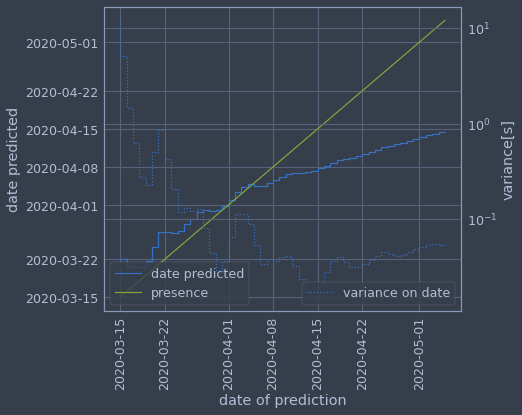

In [28]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)
plt.xlabel("date of prediction")

plt.ylabel("date predicted")

ax1.plot(x, y, label='date predicted', drawstyle='steps')
ax1.plot(x, x, label='presence')


ax2 = ax1.twinx()
ax2.semilogy(x, y_var, ":", label='variance on date', drawstyle='steps')
plt.ylabel("variance[s]")

ax1.legend(loc="lower left")
ax2.legend(loc="lower right")

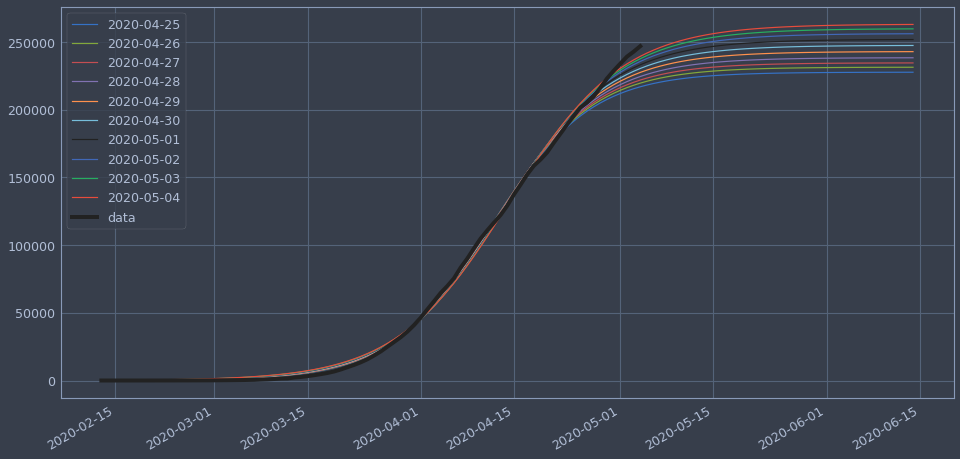

In [29]:
for e in df_exchina.index[-10:]:#[30:]:
    df_temp = df_exchina[:e]
    
    popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_temp.index, 
                       ydata = df_temp.T.sum(), 
                       p0 = (sat, td, velo)
                      )
    y_extra = sigmoid(x_extra, *list(popt))

    plt.plot(x_extra, y_extra, label=e.strftime("%Y-%m-%d"))
df_exchina.T.sum().plot(linewidth=4, style="k", label="data", figsize=(16,8))
plt.legend(loc="upper left")
plt.show()
    

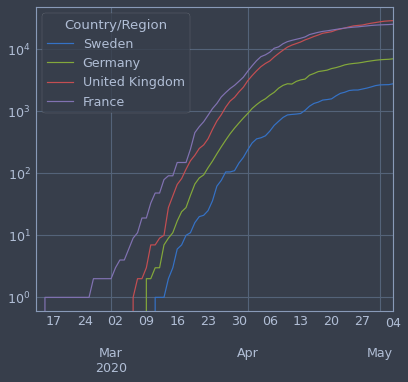

In [30]:
df_exchina[["Sweden", "Germany", "United Kingdom", "France"]].plot(logy=True)

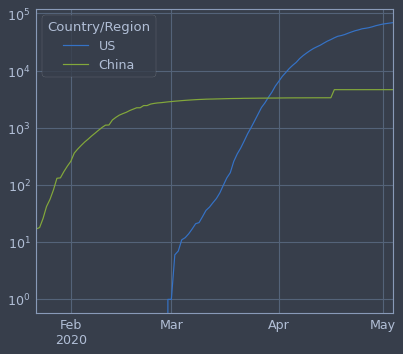

In [31]:
df2[["US", "China"]].plot(logy=True)